### Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo 

In [120]:
# Importamos las librerías que necesitamos
# 
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluar linealidad de las relaciones entre las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest
from scipy.stats import levene
from scipy.stats import mannwhitneyu


# Configuraciones
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

1. Cargamos los datos y filtramos por columnas.

In [121]:
df_todo = pd.read_csv('datos_aerolinea.csv', index_col=0)

In [122]:
df2 = df_todo[['Flights Booked', 'Education']]
df2.head()

,Flights Booked,Education
0,3,Bachelor
1,10,College
2,6,College
3,0,Bachelor
4,0,Bachelor


2. Análisis Descriptivo: Agrupa los datos por nivel educativo y calcula estadísticas 
descriptivas básicas (como el promedio, la desviación estándar, los percentiles…) del número de vuelos reservados para cada grupo

In [123]:
df2.groupby("Education")['Flights Booked'].describe()

,count,mean,std,min,25%,50%,75%,max
Education,,,,,,,,
Bachelor,252567.0,4.110288,5.221671,0.0,0.0,1.0,8.0,21.0
College,102260.0,4.169744,5.246040,0.0,0.0,1.0,8.0,21.0
Doctor,17731.0,4.175512,5.256971,0.0,0.0,1.0,8.0,21.0
High School or Below,18915.0,4.176209,5.239267,0.0,0.0,1.0,8.0,21.0
Master,12287.0,4.200700,5.213956,0.0,0.0,1.0,8.0,21.0


3. Prueba Estadística: Realiza una prueba A/B Testing para determinar si existe una 
diferencia significativa en el número de vuelos reservados entre los diferentes 
niveles educativos.

Añado al dataframe la columna "Total Flights" para poder calcular la tasa de reservas respecto de vuelos totales.

In [124]:
df_todo = pd.read_csv('datos_aerolinea.csv', index_col=0)

df = df_todo.loc[:, ['Education', 'Flights Booked', 'Total Flights']]

df['TR'] = df['Flights Booked']/ df['Total Flights']

In [125]:
df.head()

,Education,Flights Booked,Total Flights,TR
0,Bachelor,3,3,1.000000
1,College,10,14,0.714286
2,College,6,6,1.000000
3,Bachelor,0,0,NaN
4,Bachelor,0,0,NaN


Añado diferentes columnas para cada grupo con el nivel educativo que quiero estudiar (test) y el resto (control)

In [126]:
df['HSchool'] = df['Education'].apply(lambda nivel: 'HSchool' if nivel == 'High School or Below' else 'rest')

df.head()




,Education,Flights Booked,Total Flights,TR,HSchool
0,Bachelor,3,3,1.000000,rest
1,College,10,14,0.714286,rest
2,College,6,6,1.000000,rest
3,Bachelor,0,0,NaN,rest
4,Bachelor,0,0,NaN,rest


Hago lo mismo para el resto de grupos.

In [127]:

df['Bachelor'] = df['Education'].apply(lambda nivel: 'Bachelor' if nivel == 'Bachelor' else 'rest')


df['College']= df['Education'].apply(lambda nivel: 'College' if nivel == 'College' else 'rest')


df['Master']= df['Education'].apply(lambda nivel: 'Master' if nivel == 'Master' else 'rest')


df['Doctor']= df['Education'].apply(lambda nivel: 'Doctor' if nivel == 'Doctor' else 'rest')

In [128]:
df.head()

,Education,Flights Booked,Total Flights,TR,HSchool,Bachelor,College,Master,Doctor
0,Bachelor,3,3,1.000000,rest,Bachelor,rest,rest,rest
1,College,10,14,0.714286,rest,rest,College,rest,rest
2,College,6,6,1.000000,rest,rest,College,rest,rest
3,Bachelor,0,0,NaN,rest,Bachelor,rest,rest,rest
4,Bachelor,0,0,NaN,rest,Bachelor,rest,rest,rest



- Hipótesis nula, H0: no hay diferencia entre gente con estudios de instituto y el resto.

- Hipótesis alternativa, H1: sí hay diferencia.

In [129]:
#Comprobamos que las columnas de test y grupo están bien: 

df['Doctor'].unique()

array(['rest', 'Doctor'], dtype=object)

Comparo gráficamente las muestras para ver si hay diferencias.

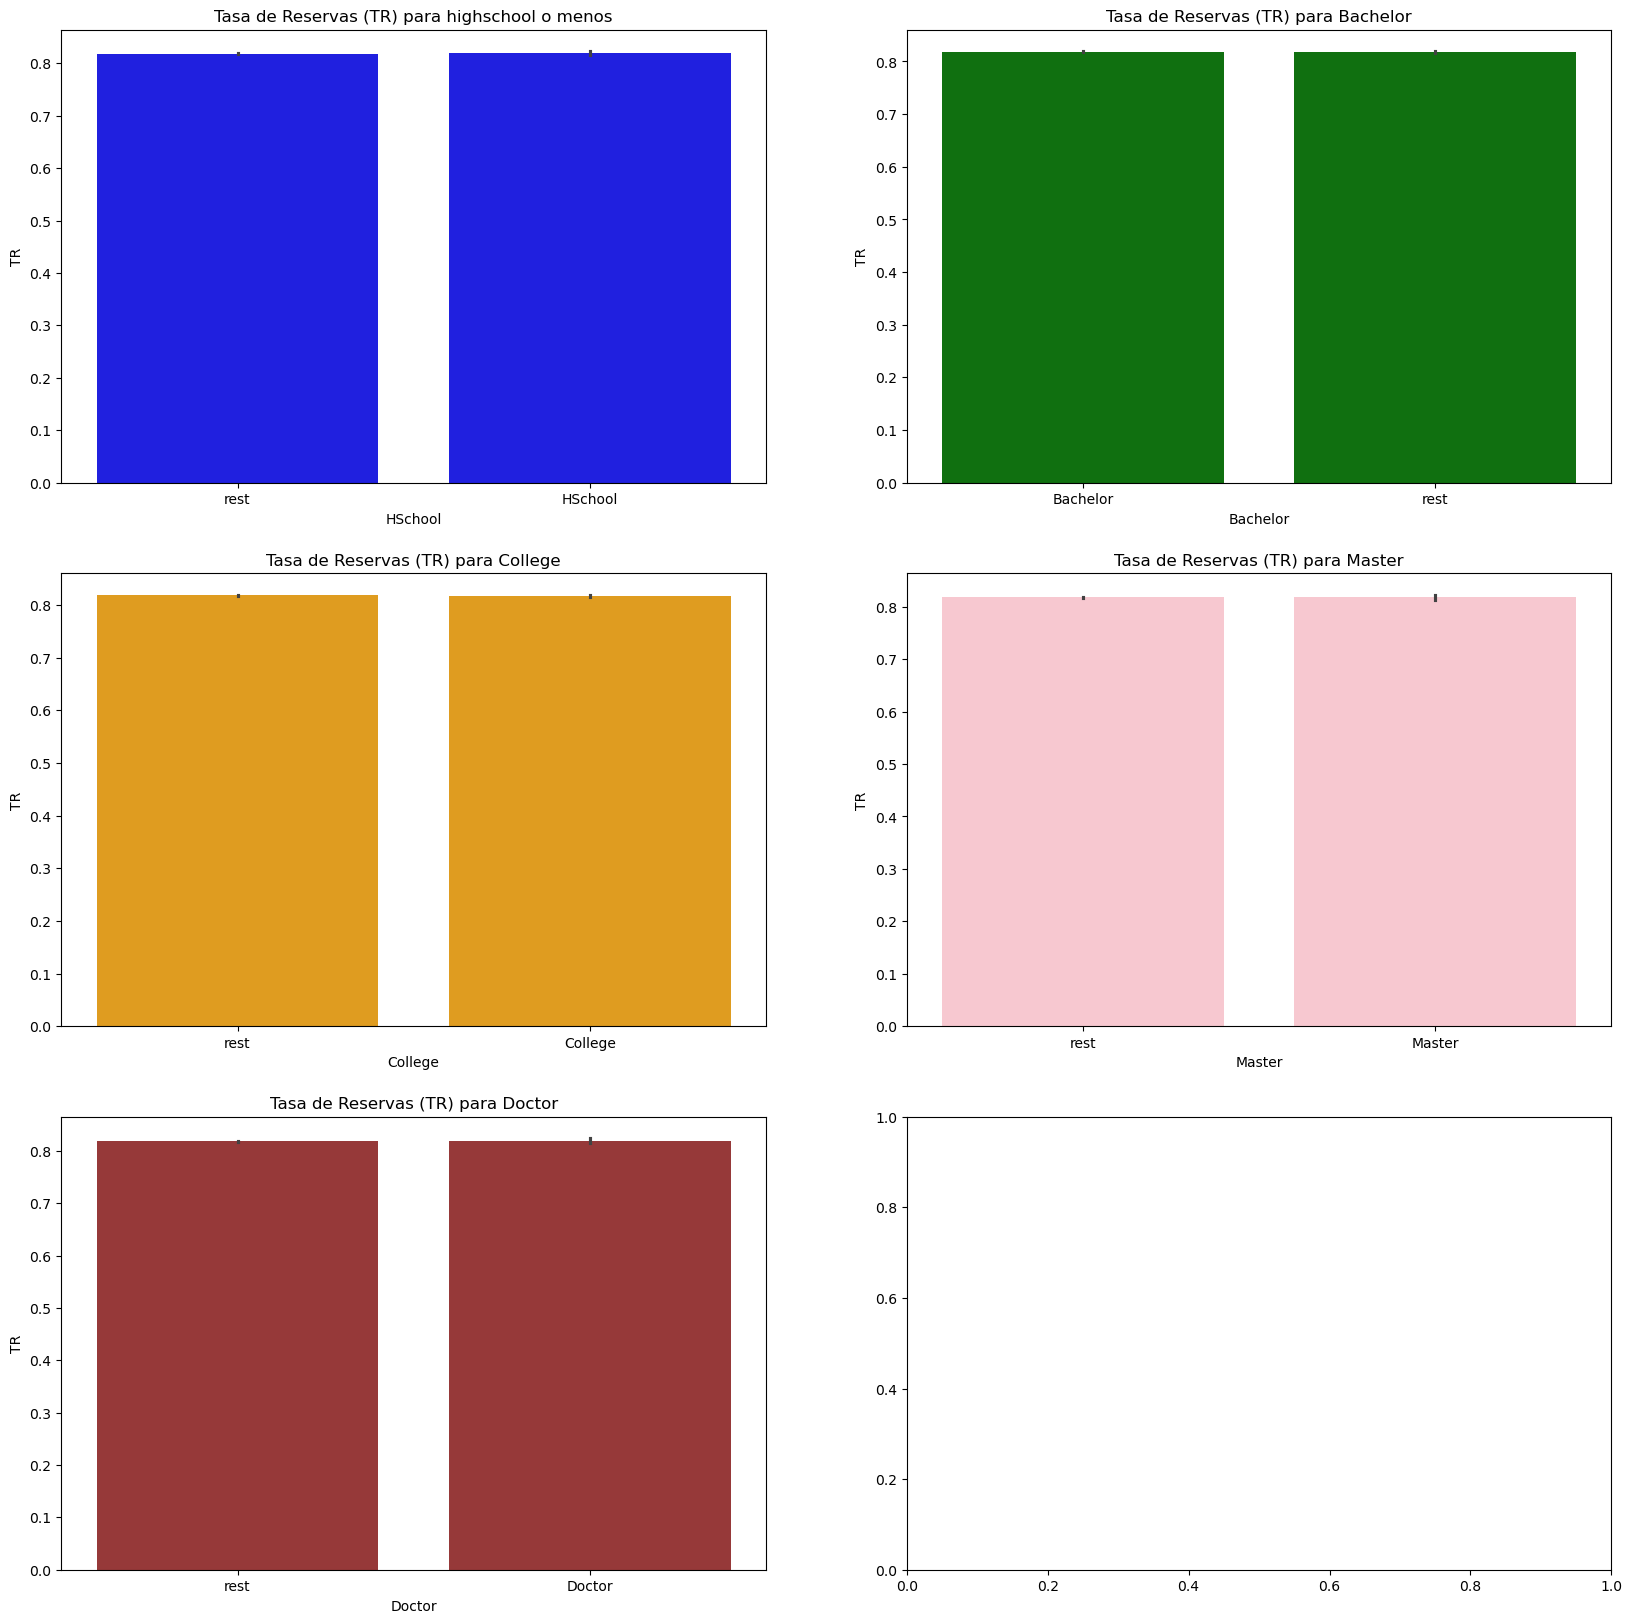

In [130]:
# Crear subgráficos
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

# Gráfico 1: Tasa de Reservas (TR) para HSchool 
sns.barplot(x="HSchool", y="TR", data=df, ax=axes[0][0], color = 'blue')
axes[0][0].set_title("Tasa de Reservas (TR) para highschool o menos")

# Gráfico 2: Tasa de Reservas (TR) para Bachelor 
sns.barplot(x="Bachelor", y="TR", data=df, ax=axes[0][1], color = 'green')
axes[0][1].set_title("Tasa de Reservas (TR) para Bachelor")

# Gráfico 3: Tasa de Reservas (TR) para College 
sns.barplot(x="College", y="TR", data=df, ax=axes[1][0], color = 'orange')
axes[1][0].set_title("Tasa de Reservas (TR) para College")

# Gráfico 4: Tasa de Reservas (TR) para Master 
sns.barplot(x="Master", y="TR", data=df, ax=axes[1][1], color = 'pink')
axes[1][1].set_title("Tasa de Reservas (TR) para Master")

# Gráfico 5: Tasa de Reservas (TR) para Doctor 
sns.barplot(x="Doctor", y="TR", data=df, ax=axes[2][0], color = 'brown')
axes[2][0].set_title("Tasa de Reservas (TR) para Doctor");


No se aprecian diferencias entre los diferentes niveles educativos.

Igualmente, para tener la prueba objetiva, habría que estudiar si las muestras difieren entre sí.

Para poder elegir la prueba estadística más apropiada, necesito evaluar la normalidad, homogeneidad e independencia de las tasas de reservas (TR) de las dos muestras. 

In [131]:
# NORMALIDAD

def normalidad(dataframe, columna):
    """
    Evalúa la normalidad de una columna de datos de un DataFrame utilizando la prueba de Shapiro-Wilk.

    Parámetros:
        dataframe (DataFrame): El DataFrame que contiene los datos.
        columna (str): El nombre de la columna en el DataFrame que se va a evaluar para la normalidad"""

    statistic, p_value = shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal.")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal.")


normalidad(df, 'TR')

Para la columna TR los datos no siguen una distribución normal.


In [132]:
# HOMOGENEIDAD

def homogeneidad (dataframe, columna, columna_metrica):
    
    """
    Evalúa la homogeneidad de las varianzas entre grupos para una métrica específica en un DataFrame dado.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que contiene los datos.
    - columna (str): El nombre de la columna que se utilizará para dividir los datos en grupos.
    - columna_metrica (str): El nombre de la columna que se utilizará para evaluar la homogeneidad de las varianzas.
    """
    
    # lo primero que tenemos que hacer es crear tantos conjuntos de datos para cada una de las categorías que tenemos, Control Campaign y Test Campaign
    valores_evaluar = []
    
    for valor in dataframe[columna].unique():
        valores_evaluar.append(dataframe[dataframe[columna]== valor][columna_metrica])

    statistic, p_value = levene(*valores_evaluar)
    if p_value > 0.05:
        print(f"Para la métrica {columna_metrica} las varianzas son homogéneas entre grupos.")
    else:
        print(f"Para la métrica {columna_metrica}, las varianzas no son homogéneas entre grupos.")


In [133]:
homogeneidad (df, 'HSchool', 'TR')

homogeneidad (df, 'Bachelor', 'TR')

homogeneidad (df, 'College', 'TR')

homogeneidad (df, 'Master', 'TR')

homogeneidad (df, 'Doctor', 'TR')

Para la métrica TR, las varianzas no son homogéneas entre grupos.
Para la métrica TR, las varianzas no son homogéneas entre grupos.
Para la métrica TR, las varianzas no son homogéneas entre grupos.
Para la métrica TR, las varianzas no son homogéneas entre grupos.
Para la métrica TR, las varianzas no son homogéneas entre grupos.


Al no ser las muestras normales ni tener varianzas homogeneas, tenemos que hacer la prueba estadística no paramétricas como el Test de Mann Whitney.

In [136]:
def test_man_whitney(dataframe, columnas_metricas, grupo_control, grupo_test, columna_grupos = "campaign_name"):

    """
    Realiza la prueba de Mann-Whitney U para comparar las medianas de las métricas entre dos grupos en un DataFrame dado.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que contiene los datos.
    - columnas_metricas (list): Una lista de nombres de columnas que representan las métricas a comparar entre los grupos.
    - grupo_control (str): El nombre del grupo de control en la columna especificada por columna_grupos.
    - grupo_test (str): El nombre del grupo de test en la columna especificada por columna_grupos.
    - columna_grupos (str): El nombre de la columna que contiene la información de los grupos. Por defecto, "campaign_name".

    Returns 
    No devuelve nada directamente, pero imprime en la consola si las medianas son diferentes o iguales para cada métrica.
    Se utiliza la prueba de Mann-Whitney U para evaluar si hay diferencias significativas entre los grupos.
    """
    # filtramos el DataFrame para quedarnos solo con los datos de control
    control = dataframe[dataframe[columna_grupos] == grupo_control]
    
    # filtramos el DataFrame para quedarnos solo con los datos de control
    test = dataframe[dataframe[columna_grupos] == grupo_test]
    
    
    # iteramos por las columnas de las metricas para ver si para cada una de ellas hay diferencias entre los grupos
    for metrica in columnas_metricas:
        
        # filtrams el conjunto de datos para quedarnos solo con la columna de la metrica que nos interesa
        metrica_control = control[metrica]
        metrica_test = test[metrica]
        
        # aplicamos el estadístico
        u_statistic, p_value = mannwhitneyu(metrica_control, metrica_test)
        
        if p_value < 0.05:
            print(f"Para la métrica {metrica}, las medianas son diferentes.")
        else:
            print(f"Para la métrica {metrica}, las medianas son iguales.")
            

Tras aplicar la prueba podríamos tener dos opciones:

a/ p_value < 0.05. Las medianas son diferentes. 
Hay diferencia significativa entre las muestras respecto a niveles educativos, pero como gráficamente no vemos diferencia no podemos decir en qué sentido.

B/ p_value > 0.05. Las medianas son iguales. No hay diferencia significativa entre las muestras respecto a niveles educativos.""" 

CONCLUSIÓN: No hay diferencias en cuanto a las reservas de los vuelos entre niveles educativos. 

In [137]:
test_man_whitney(df, 'TR', 'rest', 'HSchool', columna_grupos = 'HSchool')
test_man_whitney(df, 'TR', 'rest', 'Bachelor', columna_grupos = 'Bachelor')
test_man_whitney(df, 'TR', 'rest', 'College', columna_grupos = 'College')
test_man_whitney(df, 'TR', 'rest', 'Master', columna_grupos = 'Master')
test_man_whitney(df, 'TR', 'rest', 'Doctor', columna_grupos = 'Doctor')

KeyError: 'T'

Dicho lo anterior, estoy teniendo un error al aplicar la prueba que no me da tiempo a solucionar de cara a la entrega. Mi conclusión sigue siendo la misma: No hay diferencias en cuanto a las reservas de los vuelos entre niveles educativos. 